In [65]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tensorflow.keras import models, layers
from tensorflow.keras import callbacks
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import TensorDataset, DataLoader


In [66]:
import pandas as pd
import numpy as np


# Extract training set from MNIST dataset.
fashion_train_df = pd.read_csv('data_copy/raw/fashion-mnist-train.csv')
fashion_test_df = pd.read_csv('data_copy/raw/fashion-mnist-test.csv')


np.random.seed(0)

N = len(fashion_train_df)
indices = np.random.permutation(N)  # shuffled indices, reproducible because of seed

# this is how is suppose to be: # Calculate absolute sizes
n_train = int(0.9 * N)   # 90% of 60%
n_val = int(0.1 * N)     # 10% of 60%
comb_df = fashion_train_df  # remaining 40%


# Assign splits
idx_train = indices[:n_train]
idx_val = indices[n_train:n_train + n_val]
# idx_
# 
# 
#  = indices[n_train + n_val:]

# Get DataFrames
train_df = fashion_train_df.iloc[idx_train]
val_df = fashion_train_df.iloc[idx_val]
# comb_df = fashion_train_df.iloc[idx_comb]

print('train frame: ',len(train_df))
print('validation frame: ', len(val_df))
print('combination frame: ',len(comb_df))
print('test fram; ', len(fashion_test_df))

train frame:  54000
validation frame:  6000
combination frame:  60000
test fram;  10000


In [67]:
import torch.nn as nn
import torch.nn.functional as F
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)
        self.pool_1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.pool_2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)

        self.fc = nn.Linear(32 * 7 * 7, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool_1(x)

        x = F.relu(self.conv2(x))
        x = self.pool_2(x)

        x = F.relu(self.conv3(x))

        x = x.view(x.size(0), -1)  # flatten
        x = self.fc(x)
        return x
    
model = CNN()

from torchinfo import summary
summary(model, input_size=(64, 1, 28, 28))



Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [64, 10]                  --
├─Conv2d: 1-1                            [64, 8, 28, 28]           80
├─MaxPool2d: 1-2                         [64, 8, 14, 14]           --
├─Conv2d: 1-3                            [64, 16, 14, 14]          1,168
├─MaxPool2d: 1-4                         [64, 16, 7, 7]            --
├─Conv2d: 1-5                            [64, 32, 7, 7]            4,640
├─Linear: 1-6                            [64, 10]                  15,690
Total params: 21,578
Trainable params: 21,578
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 34.22
Input size (MB): 0.20
Forward/backward pass size (MB): 5.62
Params size (MB): 0.09
Estimated Total Size (MB): 5.91

In [68]:
import matplotlib.pyplot as plt

class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]

def show_examples(original, transformed, labels, class_names, n=5):
    """
    original: numpy array of shape (N, 28, 28)
    transformed: numpy array of shape (N, 28, 28)
    labels: array of size N with class labels (0–9)
    class_names: list of 10 class names
    """
    plt.figure(figsize=(12, 5))

    for i in range(n):
        cls = labels[i]
        name = class_names[cls]

        # Original
        plt.subplot(2, n, i+1)
        plt.imshow(original[i], cmap="gray")
        plt.title(f"Original\n{cls}: {name}")
        plt.axis("off")

        # Transformed
        plt.subplot(2, n, n + i + 1)
        plt.imshow(transformed[i], cmap="gray")
        plt.title(f"Transformed\n{cls}: {name}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


### Mixed Distribution Shift
Modify so for each class:
1. 33% rigid transformed images
2. 33% affine transformed images
3. 33% elastic deformed images

In [69]:
X = train_df.iloc[:, 1:].values.reshape(-1, 28, 28)
y = train_df["label"].values


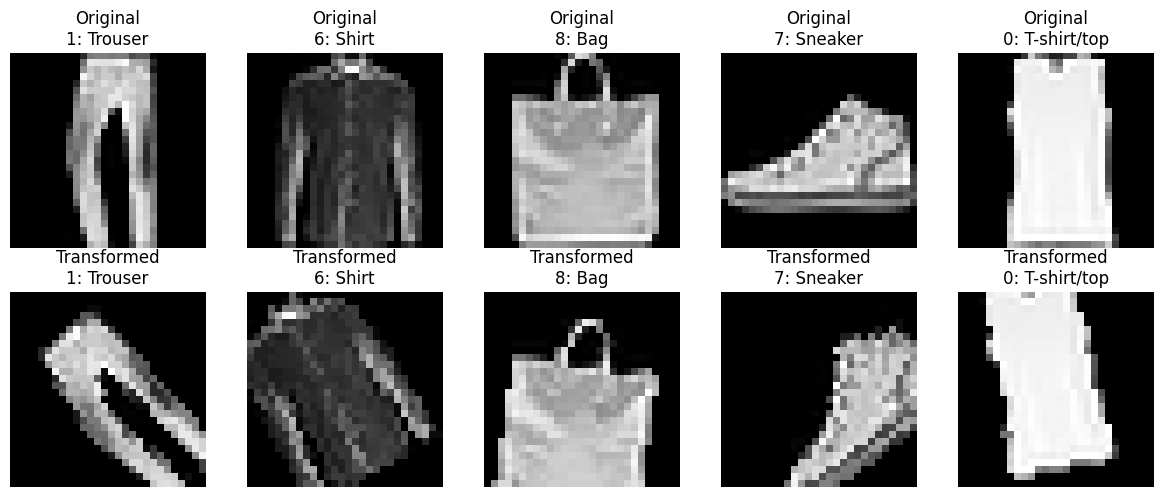

In [70]:
from torchvision import transforms as T

rigid_transform = T.RandomAffine(
    degrees=45,
    translate=(0.15, 0.15),
    scale=None,
    shear=None
)

def apply_rigid(img):
    img_pil = T.ToPILImage()(img.astype('uint8'))
    return np.array(rigid_transform(img_pil))

X_rigid = np.array([apply_rigid(img) for img in X[:5]])

show_examples(X[:5], X_rigid, y[:5], class_names, n=5)


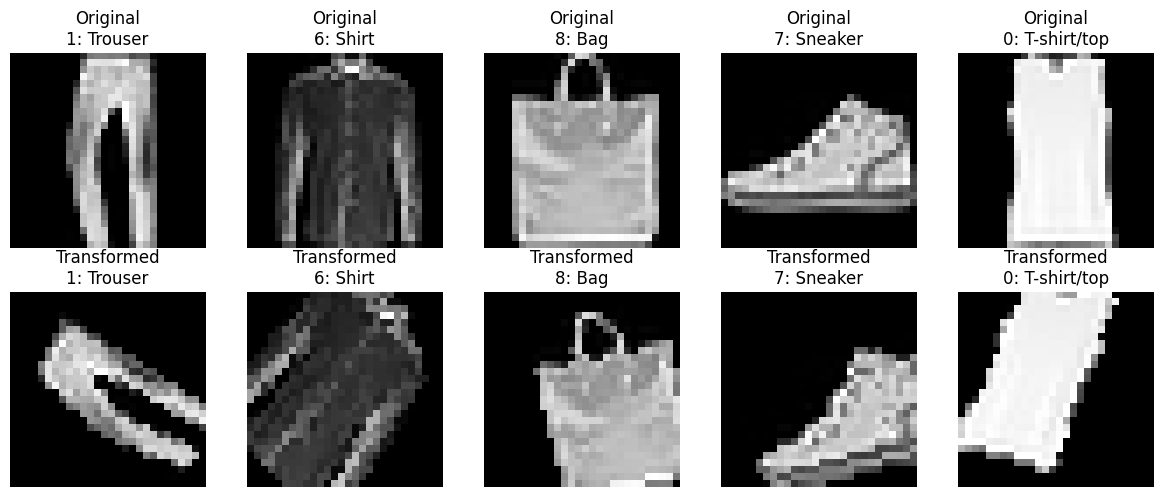

In [71]:
affine_transform = T.RandomAffine(
    degrees=90,
    translate=(0.15, 0.15),
    scale=(0.9, 1.1),
    shear=10
)

def apply_affine(img):
    img_pil = T.ToPILImage()(img.astype('uint8'))
    return np.array(affine_transform(img_pil))

X_aff = np.array([apply_affine(img) for img in X[:5]])

show_examples(X[:5], X_aff, y[:5], class_names, n=5)


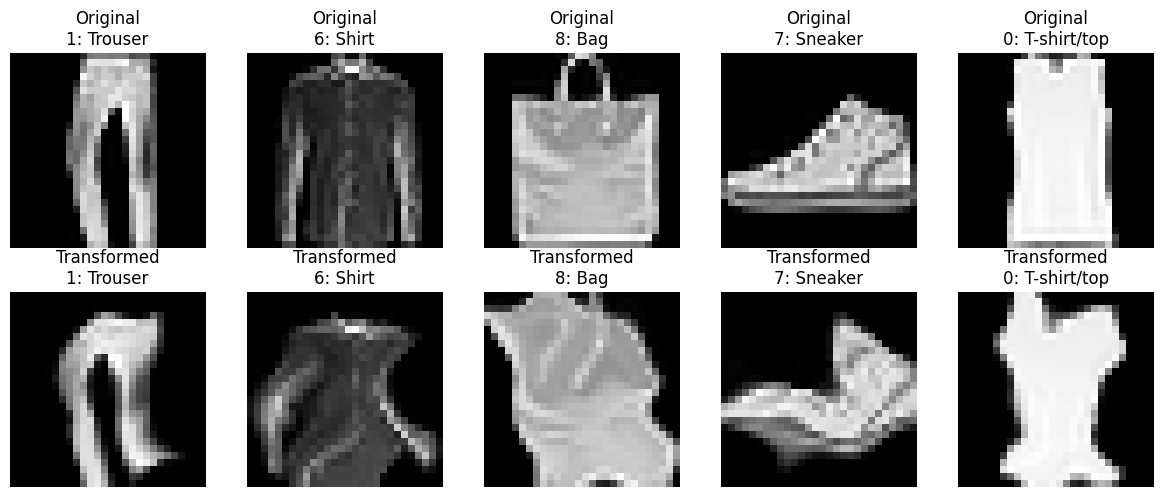

In [72]:
from torchvision.transforms import ElasticTransform

elastic_transform = ElasticTransform(alpha=70.0, sigma=3.0)

def apply_elastic(img):
    img_pil = T.ToPILImage()(img.astype('uint8'))
    return np.array(elastic_transform(img_pil))


X_elastic = np.array([apply_elastic(img) for img in X[:5]])

show_examples(X[:5], X_elastic, y[:5], class_names, n=5)


To mix the all the 3 transformation methods 

In [73]:
# AI was used here a lot!!!! 
def apply_mixed_transforms(df):
    labels = df["label"].values                        
    images = df.iloc[:, 1:].values.reshape(-1, 28, 28) # reshape pixels into 28×28

    new_images = []
    new_labels = []

    # loop over each class 0–9
    for cls in range(10):
        idx = np.where(labels == cls)[0]   # find indices of this class
        cls_imgs = images[idx]             # get the images of this class

        np.random.shuffle(cls_imgs)        # shuffle inside the class

        n = len(cls_imgs)
        n1 = n // 3                        # 33%
        n2 = 2 * n // 3                    # 66%

        # split into 3 parts
        rigid_imgs   = cls_imgs[:n1]
        affine_imgs  = cls_imgs[n1:n2]
        elastic_imgs = cls_imgs[n2:]

        # apply each transformation
        rigid_out   = [apply_rigid(img)   for img in rigid_imgs]
        affine_out  = [apply_affine(img)  for img in affine_imgs]
        elastic_out = [apply_elastic(img) for img in elastic_imgs]

        # collect them
        new_images.extend(rigid_out)
        new_images.extend(affine_out)
        new_images.extend(elastic_out)

        new_labels.extend([cls] * len(cls_imgs))   # preserve label

    # rebuild dataframe
    new_df = pd.DataFrame(
        np.array(new_images).reshape(len(new_images), -1)
    )
    new_df.insert(0, "label", new_labels)
    return new_df


train_df_mix_t= apply_mixed_transforms(train_df)
test_df_mix_t= apply_mixed_transforms(fashion_test_df)
val_df_mix_t= apply_mixed_transforms(val_df)
comb_df_mix_t = apply_mixed_transforms(comb_df)

NOT USED CURRENTLY: 

This function can be used to apply the transformation individually!!! 

In [74]:
def apply_transform_to_df(df, transform_fn):
    labels = df["label"].values
    images = df.iloc[:, 1:].values.reshape(-1, 28, 28)

    transformed_images = []
    for img in images:
        out = transform_fn(img)
        transformed_images.append(out.reshape(-1))

    new_df = pd.DataFrame(transformed_images)
    new_df.insert(0, "label", labels)
    return new_df

# Uncomment this when needed
# train_df_mix_t= apply_transform_to_df(train_df)
# test_df_mix_t= apply_transform_to_df(fashion_test_df)
# val_df_mix_t= apply_transform_to_df(val_df)
# comb_df_mix_t = apply_transform_to_df(comb_df)


In [75]:
from sklearn.model_selection import train_test_split
# Separate features (X) and labels (y) from each split
X_train = train_df_mix_t.drop("label", axis=1).values
y_train = train_df_mix_t["label"].values

X_val = val_df_mix_t.drop("label", axis=1).values
y_val = val_df_mix_t["label"].values

X_comb = comb_df_mix_t.drop("label", axis=1).values
y_comb =comb_df_mix_t["label"].values

# Also prepare test set from the test CSV
X_test = test_df_mix_t.drop("label", axis=1).values
y_test = test_df_mix_t["label"].values

# Split the combined split into train/test (80/20)
X_comb_train, X_comb_test, y_comb_train, y_comb_test = train_test_split(
    X_comb, y_comb, test_size=0.20, stratify=y_comb, random_state=0)

print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)
print("Combination:", X_comb.shape, y_comb.shape)
print("Test:", X_test.shape, y_test.shape)


# Convert NumPy arrays → PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

X_comb_train_tensor = torch.tensor(X_comb_train, dtype=torch.float32)
y_comb_train_tensor = torch.tensor(y_comb_train, dtype=torch.long)

X_comb_test_tensor  = torch.tensor(X_comb_test,  dtype=torch.float32)
y_comb_test_tensor  = torch.tensor(y_comb_test,  dtype=torch.long)
# Wrap in TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
comb_train_dataset = TensorDataset(X_comb_train_tensor, y_comb_train_tensor)
comb_test_dataset  = TensorDataset(X_comb_test_tensor,  y_comb_test_tensor)

# DataLoaders : think as a pipeline that delivers your data to the model in small, manageable pieces (batches).
# DataLoaders
batch_size = X_train.shape[0] // 20
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)
comb_train_loader = DataLoader(comb_train_dataset, batch_size, shuffle=True)
comb_test_loader  = DataLoader(comb_test_dataset,  batch_size, shuffle=False)

Train: (54000, 784) (54000,)
Validation: (6000, 784) (6000,)
Combination: (60000, 784) (60000,)
Test: (10000, 784) (10000,)


In [76]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
# This function is taken from deeplearning course assigment
def train_model(model, train_loader, val_loader, epochs=100, learning_rate=1e-3, patience=10):
    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2) # efault optimizer used in modern neural network training (used by Hugging Face, PyTorch examples, etc.).
    # optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)


    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    best_val_loss = float("inf")
    patience_counter = 0
    best_model_state = None

    start = time.perf_counter()

    for epoch in range(epochs):
        # ---- Training ----
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs = inputs.view(-1, 1, 28, 28)  # reshape
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_losses.append(running_loss / len(train_loader))
        train_accs.append(100 * correct / total)

        # ---- Validation ----
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.view(-1, 1, 28, 28)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accs.append(100 * correct / total)

        # ---- Early Stopping ---- 
        # This section is added by AI and is used in cases where we decide to try higher epoc number
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            patience_counter = 0
            best_model_state = model.state_dict()  # save best model
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                model.load_state_dict(best_model_state)  # restore best model
                break

        print(f"Epoch {epoch+1}/{epochs}: "
              f"Train Loss={train_losses[-1]:.4f}, Train Acc={train_accs[-1]:.2f}%, "
              f"Val Loss={val_losses[-1]:.4f}, Val Acc={val_accs[-1]:.2f}%")

    training_time = time.perf_counter() - start
    return train_losses, train_accs, val_losses, val_accs, training_time


In [77]:
print(batch_size)

train_losses, train_accs, val_losses, val_accs, training_time = train_model(
    model, train_loader, val_loader,
    epochs=100,         
    learning_rate=1e-4,  # safe for Adam
    patience=10
)


2700
Epoch 1/100: Train Loss=2.5681, Train Acc=25.96%, Val Loss=1.7035, Val Acc=39.28%
Epoch 2/100: Train Loss=1.5650, Train Acc=44.34%, Val Loss=1.3070, Val Acc=48.17%
Epoch 3/100: Train Loss=1.3360, Train Acc=52.28%, Val Loss=1.1253, Val Acc=53.70%
Epoch 4/100: Train Loss=1.2025, Train Acc=57.08%, Val Loss=1.0344, Val Acc=57.75%
Epoch 5/100: Train Loss=1.1145, Train Acc=60.32%, Val Loss=1.0046, Val Acc=58.75%
Epoch 6/100: Train Loss=1.0527, Train Acc=62.42%, Val Loss=0.9509, Val Acc=61.17%
Epoch 7/100: Train Loss=1.0109, Train Acc=63.92%, Val Loss=0.9203, Val Acc=62.45%
Epoch 8/100: Train Loss=0.9787, Train Acc=64.97%, Val Loss=0.9010, Val Acc=63.03%
Epoch 9/100: Train Loss=0.9488, Train Acc=66.13%, Val Loss=0.8817, Val Acc=63.68%
Epoch 10/100: Train Loss=0.9321, Train Acc=66.63%, Val Loss=0.8294, Val Acc=64.22%
Epoch 11/100: Train Loss=0.9088, Train Acc=67.41%, Val Loss=0.8500, Val Acc=64.28%
Epoch 12/100: Train Loss=0.8878, Train Acc=68.03%, Val Loss=0.8329, Val Acc=65.57%
Epoch 13

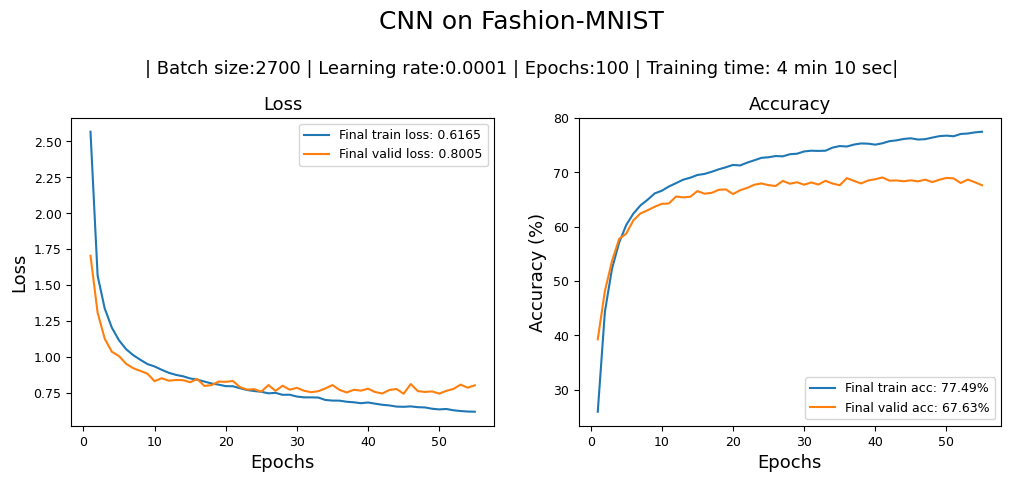

In [78]:
from matplotlib import pyplot as plt
import numpy as np

def training_curve_plot(title, train_costs, valid_costs, train_accuracies, valid_accuracies, batch_size, learning_rate, training_time, epochs):
    lg=18
    md=13
    sm=9
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(title, y=1.15, fontsize=lg)
    
    mins, secs = divmod(training_time, 60)
    sub = f'| Batch size:{batch_size} | Learning rate:{learning_rate} | Epochs:{epochs} | Training time: {int(mins)} min {secs:.0f} sec|'
    fig.text(0.5, 0.99, sub, ha='center', fontsize=md)
    
    x = range(1, len(train_costs)+1)

    # ---- Loss plot ----
    axs[0].plot(x, train_costs, label=f'Final train loss: {train_costs[-1]:.4f}')
    axs[0].plot(x, valid_costs, label=f'Final valid loss: {valid_costs[-1]:.4f}')
    axs[0].set_title('Loss', fontsize=md)
    axs[0].set_xlabel('Epochs', fontsize=md)
    axs[0].set_ylabel('Loss', fontsize=md)
    axs[0].legend(fontsize=sm)
    axs[0].tick_params(axis='both', labelsize=sm)

    # ---- Accuracy plot ----
    axs[1].plot(x, train_accuracies, label=f'Final train acc: {train_accuracies[-1]:.2f}%')
    axs[1].plot(x, valid_accuracies, label=f'Final valid acc: {valid_accuracies[-1]:.2f}%')
    axs[1].set_title('Accuracy', fontsize=md)
    axs[1].set_xlabel('Epochs', fontsize=md)
    axs[1].set_ylabel('Accuracy (%)', fontsize=md)
    axs[1].legend(fontsize=sm)
    axs[1].tick_params(axis='both', labelsize=sm)

    plt.show()

training_curve_plot(
    "CNN on Fashion-MNIST",
    train_losses,     # training loss
    val_losses,       # validation loss
    train_accs,       # training accuracy
    val_accs,         # validation accuracy
    batch_size= batch_size,
    learning_rate=1e-4,
    training_time=training_time,
    epochs=100
)


In [79]:
# Final evaluation on test set
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.view(-1, 1, 28, 28)  # adjust shape if needed
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Final Test Accuracy: {test_accuracy:.2f}%")


Final Test Accuracy: 69.00%


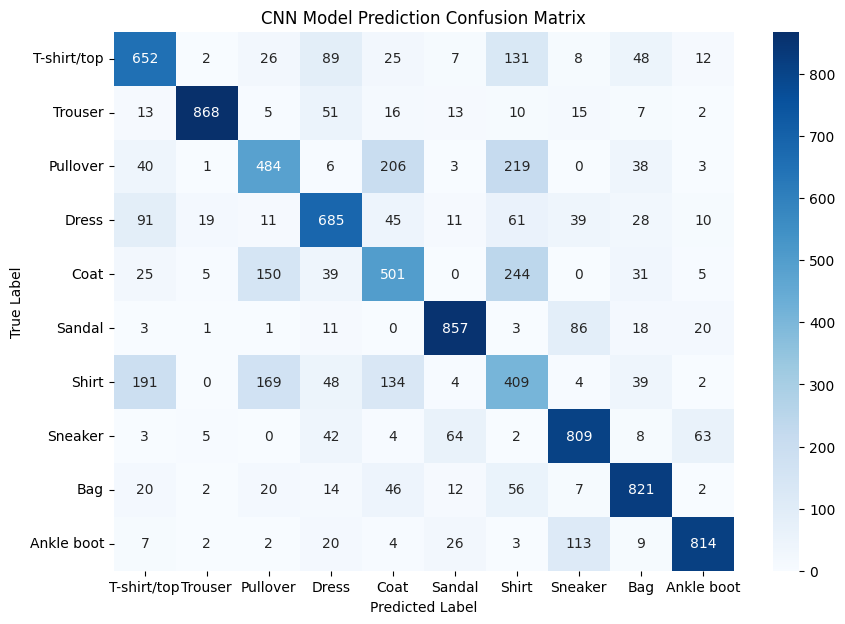

In [80]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
# AI generated and taken from Deep learning assigment 
def get_predictions(model, loader, device="cpu"):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # reshape if flattened
            if inputs.ndim == 2 and inputs.shape[1] == 784:
                inputs = inputs.view(-1, 1, 28, 28)
            
            outputs = model(inputs)  # logits
            _, preds = torch.max(outputs, 1)  # class indices

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)


class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]
# Testing the value with the testset 
y_true, y_pred_classes = get_predictions(model, test_loader)

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("CNN Model Prediction Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [81]:
print(classification_report(y_test, y_pred_classes, target_names=class_names))

              precision    recall  f1-score   support

 T-shirt/top       0.62      0.65      0.64      1000
     Trouser       0.96      0.87      0.91      1000
    Pullover       0.56      0.48      0.52      1000
       Dress       0.68      0.69      0.68      1000
        Coat       0.51      0.50      0.51      1000
      Sandal       0.86      0.86      0.86      1000
       Shirt       0.36      0.41      0.38      1000
     Sneaker       0.75      0.81      0.78      1000
         Bag       0.78      0.82      0.80      1000
  Ankle boot       0.87      0.81      0.84      1000

    accuracy                           0.69     10000
   macro avg       0.70      0.69      0.69     10000
weighted avg       0.70      0.69      0.69     10000



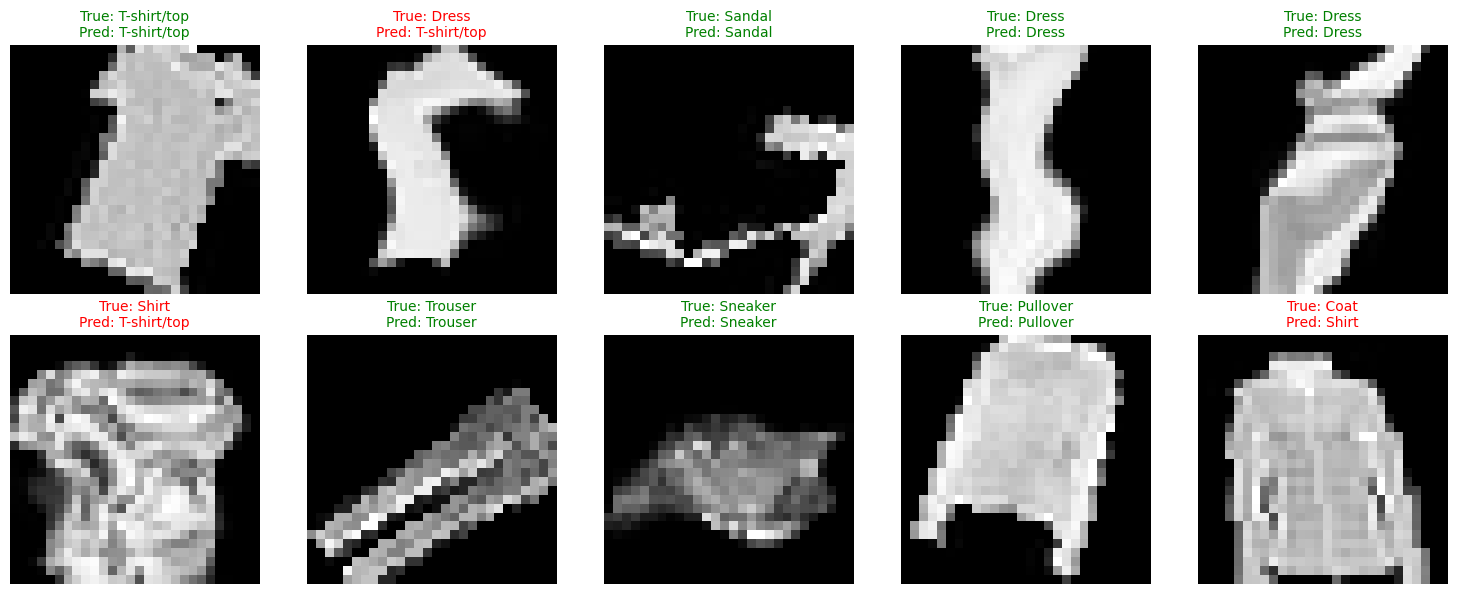

In [82]:
# This function is AI generated 
def show_random_predictions(test_loader, all_preds, all_labels, class_names, num_images=10):
    indices = np.random.choice(len(all_labels), num_images, replace=False)

    plt.figure(figsize=(15, 6))
    for i, idx in enumerate(indices):
        # Get image and true label from dataset
        image, label = test_loader.dataset[idx]
        predicted_label = all_preds[idx]

        plt.subplot(2, 5, i + 1)
        
        # If image is flattened, reshape to 28x28
        if image.ndim == 1:
            image = image.view(28, 28)
        elif image.ndim == 3:  # (1, 28, 28)
            image = image.squeeze(0)

        plt.imshow(image.cpu().numpy(), cmap="gray")
        plt.axis("off")

        # Green title if correct, red if wrong
        color = "green" if predicted_label == label else "red"
        plt.title(f"True: {class_names[label]}\nPred: {class_names[predicted_label]}",
                  fontsize=10, color=color)

    plt.tight_layout()
    plt.show()
show_random_predictions(test_loader, y_pred_classes, y_true, class_names, num_images=10)


In [83]:
# Get probabilities for combination train/test sets and save them as csvs
def get_probs_save(model_with_temp, data_loader, device, prefix="cnn", filename=None):
    model_with_temp.eval()
    all_logits, all_labels = [], []

    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            if x.ndim == 2 and x.shape[1] == 784:
                x = x.view(-1, 1, 28, 28)
            logits = model_with_temp(x)           
            scaled_logits = model_with_temp.temperature_scale(logits)
            all_logits.append(scaled_logits.cpu())
            all_labels.append(y.cpu())

    logits = torch.cat(all_logits)
    labels = torch.cat(all_labels)
    probs = F.softmax(logits, dim=1).numpy()

    ids = np.arange(len(labels))
    df = pd.DataFrame(probs, columns=[f"{prefix}_class_{i}" for i in range(probs.shape[1])])
    df.insert(0, "id", ids)
    df["true_label"] = labels.numpy()

    if filename:
        df.to_csv(filename, index=False)
        print(f"Saved {filename} ({len(df)} rows)")
    return df

Optimal temperature: 1.35
Saved cnn_MIX_T_comb_test_calibrated_predictions.csv (12000 rows)
Saved cnn_test_MIX_T_calibrated_predictions.csv (10000 rows)
Optimal temperature: 1.36
Saved cnn_dropout_train_calibrated_predictions_shift.csv (54000 rows)
Saved cnn_dropout_val_calibrated_predictions_shift.csv (6000 rows)
Saved cnn_dropout_test_calibrated_predictions_shift.csv (12000 rows)
Test Accuracy: 69.00%
NLL  before: 0.8820  after: 0.8483
ECE  before: 0.0650  after: 0.0114


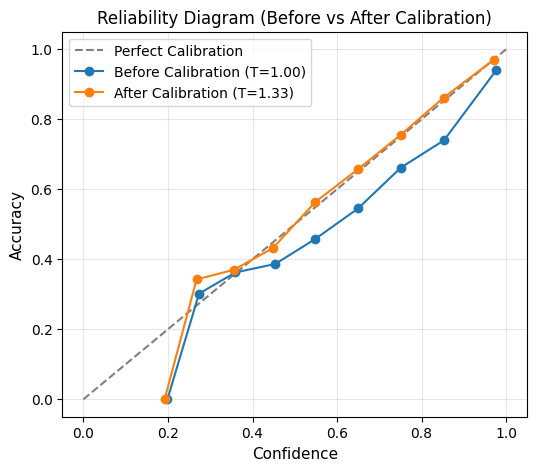

In [84]:
import torch
from torch import nn, optim
from torch.nn import functional as F

# Temperature scaling 
class ModelWithTemperature(nn.Module):
    """
    Pass raw logits (not softmax probs) through it
    """
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.temperature = nn.Parameter(torch.ones(1) * 1.5)

    def forward(self, x):
        logits = self.model(x)
        return self.temperature_scale(logits)

    def temperature_scale(self, logits):
        T = self.temperature.unsqueeze(1).expand(logits.size(0), logits.size(1))
        return logits / T

    def set_temperature(self, valid_loader, device="cpu"):
        """Fit temperature on validation set using Neg Log Likelihood Loss."""
        self.to(device)
        nll_criterion = nn.CrossEntropyLoss().to(device)

        # Get logits & labels
        logits_list, labels_list = [], []
        model_training = self.training
        self.eval()
        with torch.no_grad():
            for x, y in valid_loader:
                x, y = x.to(device), y.to(device)
                if x.ndim == 2 and x.shape[1] == 784:
                    x = x.view(-1, 1, 28, 28)
                logits_list.append(self.model(x))
                labels_list.append(y)
        logits = torch.cat(logits_list).to(device)
        labels = torch.cat(labels_list).to(device)

        # Optimise T with respect to NLL 
        optimiser = optim.LBFGS([self.temperature], lr=0.01, max_iter=200)
        def nll_loss():
            optimiser.zero_grad()
            loss = nll_criterion(self.temperature_scale(logits), labels)
            loss.backward()
            return loss
        optimiser.step(nll_loss)
        print(f"Optimal temperature: {self.temperature.item():.2f}")
        self.train(model_training)
        return self
# Negative Log-Likelihood (NLL)
def compute_nll(logits, labels):
    return nn.CrossEntropyLoss()(logits, labels).item()

# Expected Calibration Error (ECE)
def compute_ece(logits, labels, n_bins=15):
    probs = F.softmax(logits, dim=1)
    conf, pred = probs.max(dim=1)
    acc = pred.eq(labels)
    bin_boundaries = torch.linspace(0, 1, n_bins + 1)
    ece = torch.zeros(1)
    for i in range(n_bins):
        mask = (conf > bin_boundaries[i]) & (conf <= bin_boundaries[i + 1])
        if mask.any():
            prop = mask.float().mean()
            ece = ece + torch.abs(conf[mask].mean() - acc[mask].float().mean()) * prop
    return ece.item()
# Get probabilities for validation and testing set and save them as csvs
def get_probs_save(model_with_temp, data_loader, device, prefix="cnn", filename=None):
    
    model_with_temp.eval()
    all_logits, all_labels = [], []

    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            if x.ndim == 2 and x.shape[1] == 784:
                x = x.view(-1, 1, 28, 28)
            logits = model_with_temp.model(x)           
            scaled_logits = model_with_temp.temperature_scale(logits)
            all_logits.append(scaled_logits.cpu())
            all_labels.append(y.cpu())

    logits = torch.cat(all_logits)
    labels = torch.cat(all_labels)
    probs = F.softmax(logits, dim=1).numpy()

    ids = np.arange(len(labels))
    df = pd.DataFrame(probs, columns=[f"{prefix}_class_{i}" for i in range(probs.shape[1])])
    df.insert(0, "id", ids)
    df["true_label"] = labels.numpy()

    if filename:
        df.to_csv(filename, index=False)
        print(f"Saved {filename} ({len(df)} rows)")
    return df

# Calibrated predictions for the combined set and test set
device = "cuda" if torch.cuda.is_available() else "cpu"
# Find best temperature using the COMBINED data
scaled_model = ModelWithTemperature(model).to(device)
scaled_model.set_temperature(comb_train_loader, device=device)

cnn_comb_test_df = get_probs_save(
    scaled_model, comb_test_loader, device,
    prefix="cnn", filename="cnn_MIX_T_comb_test_calibrated_predictions.csv")
cnn_test_df = get_probs_save(
    scaled_model, test_loader, device,
    prefix="cnn", filename="cnn_test_MIX_T_calibrated_predictions.csv")

device = "cuda" if torch.cuda.is_available() else "cpu"

# Calibrated on the validation set
scaled_model = ModelWithTemperature(model).to(device)
scaled_model.set_temperature(val_loader, device=device)

# Get calibrated probabilities for dropout CNN on comb splits
cnn_train_calibrated_df = get_probs_save(
    scaled_model,
    train_loader,
    device=device,
    prefix="cnn_dropout_cal",
    filename="cnn_dropout_train_calibrated_predictions_shift.csv")

cnn_val_calibrated_df = get_probs_save(
    scaled_model,
    val_loader,
    device=device,
    prefix="cnn_dropout_cal",
    filename="cnn_dropout_val_calibrated_predictions_shift.csv")

cnn_test_calibrated_df = get_probs_save(
    scaled_model,
    comb_test_loader,
    device=device,
    prefix="cnn_dropout_cal",
    filename="cnn_dropout_test_calibrated_predictions_shift.csv")


# Get raw and calibrated logits 
def collect_logits(model, scaled_model, loader, device):
    raw_logits, cal_logits, labels = [], [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            if x.ndim == 2 and x.shape[1] == 784:
                x = x.view(-1, 1, 28, 28)
            out_raw = model(x)                       
            out_cal = scaled_model.temperature_scale(out_raw)
            raw_logits.append(out_raw.cpu())
            cal_logits.append(out_cal.cpu())
            labels.append(y.cpu())
    return torch.cat(raw_logits), torch.cat(cal_logits), torch.cat(labels)

logits_raw, logits_cal, labels_test = collect_logits(model, scaled_model, test_loader, device)

# Accuracy shouldn't change
acc = (logits_raw.argmax(1) == labels_test).float().mean().item() * 100
print(f"Test Accuracy: {acc:.2f}%")

# NLL & ECE before & after calibration
print(f"NLL  before: {compute_nll(logits_raw, labels_test):.4f}  "
      f"after: {compute_nll(logits_cal, labels_test):.4f}")
print(f"ECE  before: {compute_ece(logits_raw, labels_test):.4f}  "
      f"after: {compute_ece(logits_cal, labels_test):.4f}")
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

def reliability_diagram(logits, labels, n_bins=10):
    probs = F.softmax(logits, dim=1)
    conf, pred = probs.max(dim=1)
    acc = pred.eq(labels)

    bins = torch.linspace(0, 1, n_bins + 1)
    bin_accs, bin_confs = [], []

    for i in range(n_bins):
        mask = (conf > bins[i]) & (conf <= bins[i+1])
        if mask.any():
            bin_accs.append(acc[mask].float().mean().item())
            bin_confs.append(conf[mask].mean().item())

    return np.array(bin_confs), np.array(bin_accs)

# Compute bin stats (before vs after calibration)
bin_confs_raw, bin_accs_raw = reliability_diagram(logits_raw, labels_test)
bin_confs_cal, bin_accs_cal = reliability_diagram(logits_cal, labels_test)

# Plot 
plt.figure(figsize=(6, 5))
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Perfect Calibration")

plt.plot(bin_confs_raw, bin_accs_raw, marker="o", label="Before Calibration (T=1.00)", color="tab:blue")
plt.plot(bin_confs_cal, bin_accs_cal, marker="o", label="After Calibration (T=1.33)", color="tab:orange")

plt.xlabel("Confidence", fontsize=11)
plt.ylabel("Accuracy", fontsize=11)
plt.title("Reliability Diagram (Before vs After Calibration)", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.show()


#### Generate predictions on different degradation levels

In [85]:
N_PIXELS = 28 * 28  # 784
N_CLASSES = 10
DEGRADATION_TRAIN = 0.85

# with only one GPU device, a single chain is what we can do easily. One can of course run multiple runs
# but the pymc library wont do chains in parallell if trying a GPU sampler and with just 1 GPU available
N_CHAINS = 1

# We make 1k posterior samples in the one chain.
# if running on CPU of multiple GPUs one could have fewer samples per chain.
# more chains = more precise computation
# I did a first rough run, and adding more samples did not seems to alter the quality that much
# so 1k should be fine, I think
N_DRAWS = 1000
RANDOM_SEED = 42

# For data degradation, we need a fixed sequence in which we degrade pixels
rng = np.random.default_rng(RANDOM_SEED)
PIXEL_PERMUTATION = rng.permutation(N_PIXELS)
print(f"   Pixel permutation generated and fixed with seed {RANDOM_SEED}.")

def degrade_images(X, degradation_percentage):
    """
    Degrades a copy of the image data by setting a percentage of pixels to zero.
    The pixel choice is determined by a fixed, deterministic order.
    """
    X_degraded = X.copy()

    # Degradation is cumulative:
    # 50% degradation means the first 50% of pixels in the fixed order are nulled.
    # 75% degradation nulls the same 50% and then another 25 percentage points
    num_to_null = int(N_PIXELS * degradation_percentage)
    indices_to_null = PIXEL_PERMUTATION[:num_to_null]

    # Set the selected pixels to the sentinel value zero across all images
    # Axis 0 is the image index, axis 1 is the pixel index
    X_degraded[:, indices_to_null] = 0.0 # Sentinel value zero

    return X_degraded

# Degrade the training data once and for all
# X_train_degraded = degrade_images(X_train_flat, DEGRADATION_TRAIN)
# print(f"Training data degraded at {DEGRADATION_TRAIN:.0%}")


   Pixel permutation generated and fixed with seed 42.


In [86]:
# Degradation levels predictions will be performed on the test set
df_test = pd.DataFrame(X_test)
df_test.insert(0, 'label', y_test)

In [87]:
# Extract labels and pixel matrix
labels = df_test.iloc[:, 0].to_numpy()
X_test = df_test.iloc[:, 1:].to_numpy()
# Set manual degradation levels
degradation_levels = [0.0, 0.10, 0.20, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
degraded_datasets = {}

for level in degradation_levels:
    # Use new degradation function
    X_degraded = degrade_images(X_test, degradation_percentage=level)

    # Convert back to DataFrame to match old API
    degraded_df = pd.DataFrame(X_degraded, columns=df_test.columns[1:])
    degraded_df.insert(0, "label", labels)

    # Store dataset in dictionary
    degraded_datasets[level] = degraded_df


In [88]:
import torch.nn.functional as F

# Predict probabilities function to use for all degradation levels
def predict_probs(model, X, device="cpu", batch_size=256):
    model.eval()
    probs_list = []
    # No gradient 
    with torch.no_grad():
        for i in range(0, len(X), batch_size):
            batch = torch.tensor(X[i:i+batch_size]).float().to(device)
            if batch.ndim == 3:
                batch = batch.unsqueeze(1)  
            outputs = model(batch)
            probs = F.softmax(outputs, dim=1)
            probs_list.append(probs.cpu().numpy())
    
    return np.concatenate(probs_list, axis=0)


In [89]:
from sklearn.metrics import accuracy_score, log_loss
# results per dropout level for saving 
cnn_dropout_results = []

# separate data from true label 
for level, df_deg in degraded_datasets.items():
    y_true = df_deg["label"].to_numpy()
    X_deg = df_deg.iloc[:, 1:].to_numpy().reshape(-1, 28, 28)  
    # get the probs 
    probs = predict_probs(scaled_model, X_deg, device=device)
    preds = probs.argmax(axis=1)
    # accuracy and nll 
    acc = accuracy_score(y_true, preds) * 100
    nll = log_loss(y_true, probs)
    # save the results for later plot
    cnn_dropout_results.append({
        "Degradation": level,
        "Accuracy (%)": acc,
        "NLL": nll})


    Degradation  Accuracy (%)        NLL
0           0.0         69.00   0.848323
1           0.1         55.33   1.258706
2           0.2         45.58   1.720762
3           0.3         36.01   2.529649
4           0.4         29.94   3.244889
5           0.5         23.79   4.572269
6           0.6         18.91   6.381926
7           0.7         15.22   8.076297
8           0.8         13.54  10.073382
9           0.9         13.18  10.788451
10          1.0         10.00   2.386598


C:\Users\saber\AppData\Local\Temp\ipykernel_23236\373086459.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


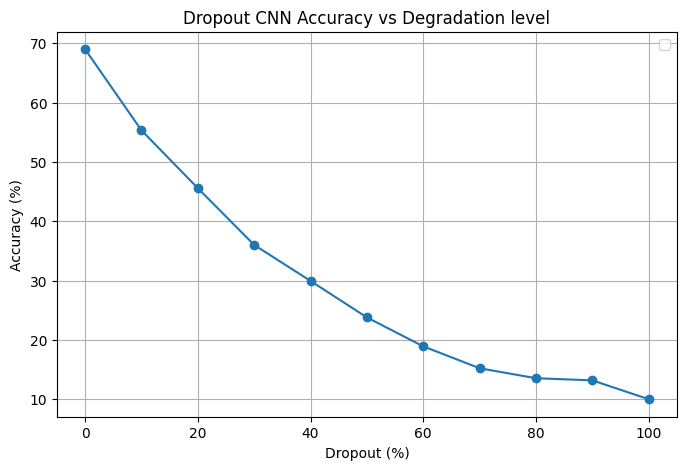

In [90]:
cnn_dropout_results_df = pd.DataFrame(cnn_dropout_results)
print(cnn_dropout_results_df)

plt.figure(figsize=(8,5))
plt.plot(cnn_dropout_results_df["Degradation"]*100, cnn_dropout_results_df["Accuracy (%)"], 'o-')
plt.xlabel("Dropout (%)")
plt.ylabel("Accuracy (%)")
plt.title("Dropout CNN Accuracy vs Degradation level")
plt.grid(True)
plt.legend()
plt.show()


In [91]:
for level, df_deg in degraded_datasets.items():
    y_true = df_deg["label"].to_numpy()
    X_deg = df_deg.iloc[:, 1:].to_numpy().reshape(-1, 28, 28)
    
    probs = predict_probs(scaled_model, X_deg, device=device)
    
    preds_df = pd.DataFrame(probs, columns=[f"cnn_dropout_MixT_class_{i}" for i in range(probs.shape[1])])
    preds_df["true_label"] = y_true
    preds_df.to_csv(f"cnn_dropout_MixT_test_predictions_degradation_{int(level*100)}.csv", index=False)
    print(preds_df.shape)


(10000, 11)
(10000, 11)
(10000, 11)
(10000, 11)
(10000, 11)
(10000, 11)
(10000, 11)
(10000, 11)
(10000, 11)
(10000, 11)
(10000, 11)
